In [1]:
!pip3 install pandas
!pip3 install xgboost
!pip3 install sklearn
!pip3 install six==1.10
!pip3 install matplotlib
!pip3 install statsmodels

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import math

from xgboost.sklearn import XGBClassifier
from xgboost.sklearn import XGBRegressor
from xgboost import plot_tree

#from graphviz import Digraph

from sklearn import cross_validation, metrics
from sklearn import preprocessing
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor

import statsmodels.api as sm

from math import sqrt

%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

/usr/lib/python3.4/importlib/_bootstrap.py:321: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.4/importlib/_bootstrap.py:321: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.4/importlib/_bootstrap.py:321: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.4/importlib/_bootstrap.py:321: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.4/importlib/_bootstrap.py:321: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/local/lib/python3.4/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 i

# Load Data

In [3]:
kyoto_1_score = pd.read_csv('dataset/data1_score.csv')
kyoto_1_score.head(5)

,userid,score
0,ds101,80
1,ds102,80
2,ds103,60
3,ds104,50
4,ds105,100


In [4]:
kyoto_1_all = pd.read_csv('dataset/dataset1_features.csv')
kyoto_1_p1 = pd.read_csv('dataset/total01_1213.csv')
kyoto_1_p2 = pd.read_csv('dataset/total01_0123~0124.csv')
kyoto_1_p3 = pd.read_csv('dataset/total01_1122.csv')

# Merge Datasets

In [5]:
kyoto_x_all = pd.merge(kyoto_1_all, kyoto_1_score, on='userid')
kyoto_x_1 = pd.merge(kyoto_1_p1, kyoto_1_score, on='userid')
kyoto_x_2 = pd.merge(kyoto_1_p2, kyoto_1_score, on='userid')
kyoto_x_3 = pd.merge(kyoto_1_p3, kyoto_1_score, on='userid')

In [6]:
kyoto_x_p = kyoto_x_1.append([kyoto_x_2, kyoto_x_3])
kyoto_x_p.rename(index=str, columns={"ADD BOOKMARK": "Add_BookmarkC"}, inplace=True)
kyoto_x_p.rename(index=str, columns={"CLOSE": "closec"}, inplace=True)
kyoto_x_p.rename(index=str, columns={"MARKERC": "markerc"}, inplace=True)
kyoto_x_p.rename(index=str, columns={"MEMOC": "memoc"}, inplace=True)
kyoto_x_p.rename(index=str, columns={"OPEN": "openc"}, inplace=True)
kyoto_x_p.rename(index=str, columns={"PAGE_JUMP": "Page_JumpC"}, inplace=True)
kyoto_x_p.rename(index=str, columns={"mobile": "mobilec"}, inplace=True)
kyoto_x_p.rename(index=str, columns={"pc": "pcc"}, inplace=True)
kyoto_x_p.rename(index=str, columns={"tablet": "tabletc"}, inplace=True)
set(kyoto_x_p) - set(kyoto_x_all)

set()

In [7]:
kyoto_1 = kyoto_x_all
kyoto_1 = kyoto_x_p
#kyoto_1 = pd.concat([kyoto_x_all, kyoto_x_p])
kyoto_1.fillna(0.0, inplace=True)
kyoto_1 = kyoto_1.drop(['userid'], axis=1)

#list(kyoto_1)[11]

kyoto_1 = kyoto_1.drop([list(kyoto_1)[14]], axis=1)

# Preprocess

In [8]:

outlier = 3
kyoto_1 = kyoto_1[np.abs(kyoto_1.pcc-kyoto_1.pcc.mean()) <= (outlier * kyoto_1.pcc.std())]
kyoto_1 = kyoto_1[np.abs(kyoto_1.tabletc-kyoto_1.tabletc.mean()) <= (outlier * kyoto_1.tabletc.std())]
#kyoto_1 = kyoto_1 * 10
#kyoto_1 = np.log(kyoto_1)
#kyoto_1.fillna(0.0, inplace=True)
#kyoto_1 = (kyoto_1 - kyoto_1.mean()) / (kyoto_1.max() - kyoto_1.min()) * 10
#kyoto_1.fillna(0.0, inplace=True)

kyoto_1
#kyoto_1.plot.box(sym='r+')

,SEARCH,PREV,NEXT,BacktrackRate(PrevC/NextC),Readtime(seconds),LINK_CLICK,SEARCH_JUMP,Page_JumpC,JUMPC,openc,closec,pcc,mobilec,tabletc,memoc,markerc,score
0,0.0,57.0,65,0.876923,273,0.0,0.0,8.0,8.0,1,0.0,131.0,0.0,0.0,0.0,0.0,80
1,0.0,17.0,118,0.144068,2561,0.0,0.0,2.0,2.0,1,0.0,138.0,0.0,0.0,0.0,0.0,100
2,0.0,80.0,158,0.506329,3799,0.0,0.0,0.0,0.0,1,0.0,239.0,0.0,0.0,0.0,0.0,90
3,0.0,4.0,71,0.056338,203,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,76.0,0.0,0.0,100
4,0.0,8.0,80,0.100000,853,0.0,0.0,0.0,0.0,1,1.0,90.0,0.0,0.0,0.0,0.0,50
5,0.0,3.0,16,0.187500,67,0.0,0.0,4.0,4.0,2,0.0,0.0,25.0,0.0,0.0,0.0,100
6,0.0,29.0,112,0.258929,731,0.0,0.0,0.0,0.0,5,0.0,0.0,146.0,0.0,0.0,0.0,60
7,0.0,34.0,112,0.303571,4021,0.0,0.0,0.0,0.0,1,0.0,147.0,0.0,0.0,0.0,0.0,100
8,0.0,31.0,102,0.303922,217,0.0,0.0,0.0,0.0,1,0.0,134.0,0.0,0.0,0.0,0.0,95
9,0.0,0.0,7,0.000000,20,0.0,0.0,0.0,0.0,2,0.0,0.0,9.0,0.0,0.0,0.0,20


In [9]:

kyoto_y = kyoto_1['score']
kyoto_x = kyoto_1.drop(['score'], axis=1) / 20

# Train Model

In [10]:
xgb2 = XGBRegressor(n_estimators=100, 
                    learning_rate=0.08, 
                    gamma=0, 
                    subsample=0.75,
                    colsample_bytree=0.8, 
                    max_depth=5)

In [11]:
mlp = MLPRegressor(hidden_layer_sizes=(1,),
                   activation='relu',
                   solver='adam',
                   learning_rate='adaptive',
                   max_iter=1000,
                   learning_rate_init=0.01,
                   alpha=0.01)

In [12]:
mse_xgb_list = []
mse_pcx_list = []
mse_ols_list = []
mse_svr_list = []
mse_mlp_list = []
mse_pcr_list = []
mse_regr_list = []

for i in range(0, 100):
    X_train, X_test, y_train, y_test = train_test_split(kyoto_x, kyoto_y, test_size=0.3)
    
    # XGBoost
    xgb2.fit(X_train, y_train)
    xgr_pred_y = xgb2.predict(X_test)
    mse_xgb_list.append(sqrt(mean_squared_error(y_test, xgr_pred_y)))
    
    # PCX
    pca = PCA(n_components=16)# adjust yourself
    pca.fit(X_train)
    X_pca_train = pca.transform(X_train)
    X_pca_test = pca.transform(X_test)    
    xgb2.fit(X_pca_train, y_train)
    pcx_pred_y = xgb2.predict(X_pca_test)
    mse_pcx_list.append(sqrt(mean_squared_error(y_test, pcx_pred_y)))
    
    # Random Forest Regressor
    regr = RandomForestRegressor(max_depth=5, random_state=0)
    regr.fit(X_train, y_train)
    regr_pred_y = regr.predict(X_test)
    mse_regr_list.append(sqrt(mean_squared_error(y_test, regr_pred_y)))
    
    # linear regression
    ols_model = sm.OLS(endog=y_train, exog=X_train, missing='drop')
    ols_model = ols_model.fit()
    ols_pred_y = ols_model.predict(exog=X_test)
    mse_ols_list.append(sqrt(mean_squared_error(y_test, ols_pred_y)))
    
    # support vector regression
    clf = SVR(C=1.0, epsilon=0.2)
    svr_model = clf.fit(X_train, y_train) 
    svr_pred_y = svr_model.predict(X_test)
    mse_svr_list.append(sqrt(mean_squared_error(y_test, svr_pred_y)))
    
    # Multi-layer Perceptron regressor
    mlp_model = mlp.fit(X_train, y_train)
    mlp_pred_y = mlp_model.predict(X_test)
    mse_mlp_list.append(sqrt(mean_squared_error(y_test, mlp_pred_y)))
    
    # Princple Componment Regression
    pca = PCA(n_components=16)# adjust yourself
    pca.fit(X_train)
    X_pca_train = pca.transform(X_train)
    X_pca_test = pca.transform(X_test)
    pcr_model = sm.OLS(endog=y_train, exog=X_pca_train, missing='drop')
    pcr_model = pcr_model.fit()
    pcr_pred_y = pcr_model.predict(exog=X_pca_test)
    mse_pcr_list.append(sqrt(mean_squared_error(y_test, pcr_pred_y)))


# Boxplot

[Text(0,0,'XGBoost'),
 Text(0,0,'PCXGBoox'),
 Text(0,0,'RFR'),
 Text(0,0,'SVR'),
 Text(0,0,'ANN'),
 Text(0,0,'PCR')]

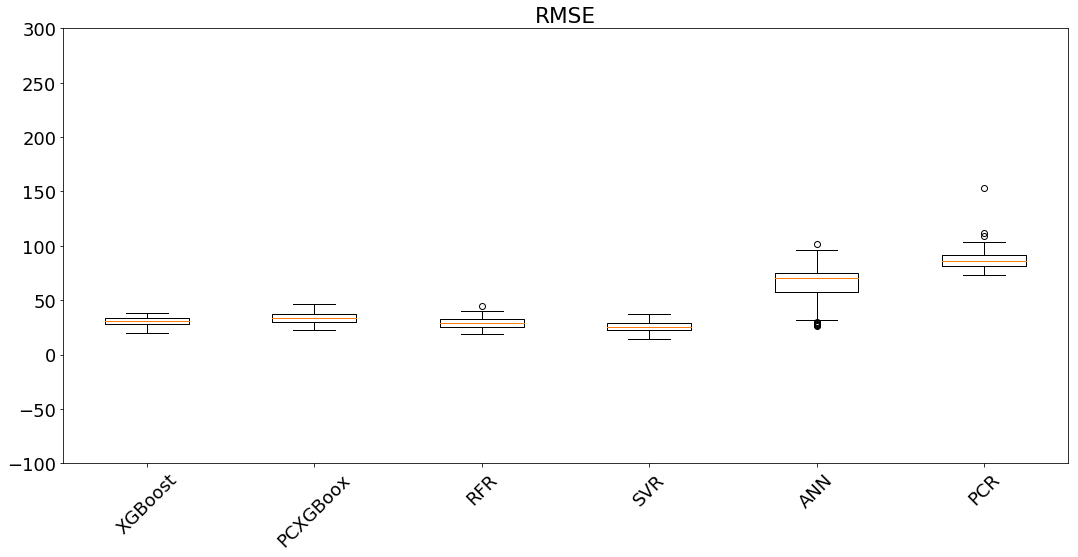

In [13]:
matplotlib.rcParams.update({'font.size': 18})

fig1, ax1 = plt.subplots(figsize=(18, 8))
ax1.set_title('RMSE')
box_data = [mse_xgb_list, 
            mse_pcx_list, 
            mse_regr_list,
            mse_svr_list, 
            mse_mlp_list, 
            mse_pcr_list]

#ax1.set_yscale('log')
ax1.boxplot(box_data)
ax1.set_ylim([-100, 300])
ax1.set_xticklabels(['XGBoost', 
                     'PCXGBoox', 
                     'RFR', 
                     'SVR', 
                     'ANN', 
                     'PCR'], rotation=45)

In [14]:
print ('XGBoost:', sum(mse_xgb_list) / len(mse_xgb_list))
print ('PCXGBoost:', sum(mse_pcx_list) / len(mse_pcx_list))
print ('Random Forest Regression:', sum(mse_regr_list) / len(mse_regr_list))
print ('Support Vector Regression:', sum(mse_svr_list) / len(mse_svr_list))
print ('Artificial Neural Network :', sum(mse_mlp_list) / len(mse_mlp_list))
print ('Principle Component Regression:', sum(mse_pcr_list) / len(mse_pcr_list))

XGBoost: 30.377507632322246
PCXGBoost: 33.17664420627263
Random Forest Regression: 28.948856059946408
Support Vector Regression: 25.65152950171641
Artificial Neural Network : 64.75056359350691
Principle Component Regression: 98.7311975354754
